In [1]:
results_glob_pattern = 'logs/2018-12-0[567]*'

In [2]:
# Parameters
results_glob_pattern = "logs/2018-12-0[567]*"


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
import seaborn as sns
import json

import glob

from pygmo import hypervolume

In [4]:
results_dirs_tt = glob.glob(results_glob_pattern)
results_dirs_tt

['logs/2018-12-05_23-10-24',
 'logs/2018-12-06_08-40-43',
 'logs/2018-12-05_23-20-38',
 'logs/2018-12-06_03-59-51',
 'logs/2018-12-07_08-52-57',
 'logs/2018-12-06_03-57-28',
 'logs/2018-12-06_13-36-20',
 'logs/2018-12-07_04-03-49',
 'logs/2018-12-07_08-54-52',
 'logs/2018-12-06_23-02-56',
 'logs/2018-12-06_09-08-34',
 'logs/2018-12-05_13-48-35',
 'logs/2018-12-06_13-47-42',
 'logs/2018-12-05_18-28-44',
 'logs/2018-12-06_08-48-46',
 'logs/2018-12-06_23-22-29',
 'logs/2018-12-05_18-31-53',
 'logs/2018-12-05_23-12-01',
 'logs/2018-12-05_23-25-21',
 'logs/2018-12-06_13-35-19',
 'logs/2018-12-06_08-47-18',
 'logs/2018-12-05_13-47-15',
 'logs/2018-12-07_03-51-02',
 'logs/2018-12-06_18-27-28',
 'logs/2018-12-06_13-32-38',
 'logs/2018-12-06_04-14-07',
 'logs/2018-12-06_23-00-12',
 'logs/2018-12-06_04-15-10',
 'logs/2018-12-06_18-17-35',
 'logs/2018-12-07_03-42-33',
 'logs/2018-12-05_13-46-29',
 'logs/2018-12-05_18-30-02',
 'logs/2018-12-07_08-36-57',
 'logs/2018-12-05_18-47-00',
 'logs/2018-12

In [5]:
def get_objectives(dir_name):
    objectives = []
    
    with open(dir_name + '/test_fits.csv') as test_f,\
        open(dir_name + '/train_fits.csv') as train_f,\
        open(dir_name + '/test_max_peaks.csv') as test_mp,\
        open(dir_name + '/train_max_peaks.csv') as train_mp:
            test_f_reader = csv.DictReader(test_f, delimiter=';')
            train_f_reader = csv.DictReader(train_f, delimiter=';')
            test_mp_reader = csv.DictReader(test_mp, delimiter=';')
            train_mp_reader = csv.DictReader(train_mp, delimiter=';')
            
            reader_iterator = zip(test_f_reader,
                                  train_f_reader,
                                  test_mp_reader,
                                  train_mp_reader)
            
            for tef, trf, temp, trmp in reader_iterator:
                te_instance = (
                    tef["individual_id"],
                    eval(tef["fitness"])[0],
                    eval(tef["fitness"])[1],
                    float(temp["max_peak"]),
                    'test')
                
                tr_instance = (
                    trf["individual_id"],
                    eval(trf["fitness"])[0],
                    eval(trf["fitness"])[1],
                    float(trmp["max_peak"]),
                    'train')
                
                objectives.extend([te_instance, tr_instance])
    return objectives

In [6]:
def get_objectives_df(dir_name, run_id):
    df = pd.DataFrame(get_objectives(dir_name), columns="id cost green max_peak train_test".split())
    df["run_id"] = run_id
    return df

In [7]:
results_tt_dfs = [get_objectives_df(dir_name, dir_name.split('/')[-1]) for dir_name in results_dirs_tt]
results_tt_df = pd.concat(results_tt_dfs)

In [8]:
results_tt_df.head()

id       cost      green  max_peak  \
0  fb16165d-43b8-4226-92ef-e61a0338da6f -19.955363  31.704270  1.520417   
1  fb16165d-43b8-4226-92ef-e61a0338da6f -50.846516  23.721851  1.339533   
2  b1a1f525-605d-4ebb-b7cc-8ea39cee934b -19.955363  31.704270  1.520417   
3  b1a1f525-605d-4ebb-b7cc-8ea39cee934b -50.846516  23.721851  1.339533   
4  fd7c7482-cffc-457a-bafa-4d69a8eeb593  -7.793008   7.831822  1.424016   

  train_test               run_id  
0       test  2018-12-05_23-10-24  
1      train  2018-12-05_23-10-24  
2       test  2018-12-05_23-10-24  
3      train  2018-12-05_23-10-24  
4       test  2018-12-05_23-10-24

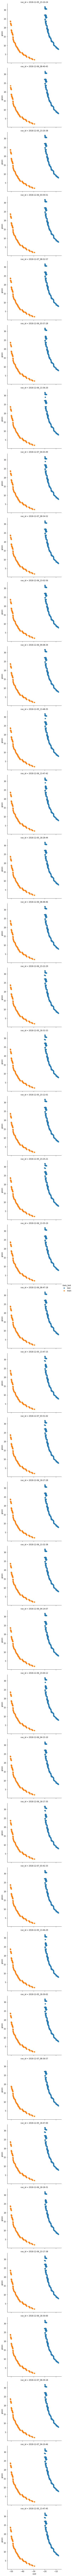

In [9]:
sns.lmplot("cost", "green", results_tt_df, hue="train_test", fit_reg=False, row="run_id");

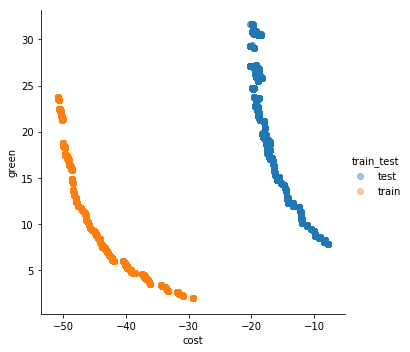

In [10]:
sns.lmplot("cost", "green", results_tt_df,
           hue="train_test", fit_reg=False,
           scatter_kws=dict(alpha=0.4));

In [11]:
def get_generations_pop_log(fp):
    generations = []
    with open(fp) as ff:
        for line in ff:
            ind_json = json.loads(line)
            ind = (
                ind_json.get("uuid"),
                ind_json.get("fitness")[0],
                ind_json.get("fitness")[1],
                ind_json.get("max_peak"),
                ind_json.get("gen"),
            )
            generations.append(ind)
    return generations

In [12]:
def get_generations_pop_log_df(fp):
    df = pd.DataFrame(get_generations_pop_log(fp),
                      columns="id cost green max_peak gen".split())
    df["run_id"] = fp.split('/')[-2]
    return df

In [13]:
def get_hvs(fp, ref_point=None):
    gen_df = get_generations_pop_log_df(fp)
    
    if ref_point is None:
        print("Reference point will be computed from the data.")
        ref_point_coef = np.sign(gen_df[["cost", "green"]].max().values) * 0.1 + 1
        ref_point = ref_point_coef * gen_df[["cost", "green"]].max().values
    grouped = gen_df.groupby('gen')
    hvs = []
    for i, group in grouped:
        fits = group[["cost", "green"]]
        hvs.append((i,
                   hypervolume(fits.values).compute(ref_point)))
    return hvs

In [14]:
def get_hvs_df(fp, ref_point=None):
    hvs = get_hvs(fp, ref_point)
    
    hvs_df = pd.DataFrame(hvs, columns="gen hv".split())
    hvs_df["run_id"] = fp.split("/")[-2]
    return hvs_df

In [15]:
def compute_ref_point(df):
    ref_point_coef = np.sign(df[["cost", "green"]].max().values) * 0.1 + 1
    ref_point = ref_point_coef * df[["cost", "green"]].max().values
    return ref_point

In [16]:
def get_all_hvs(result_dirs):
    all_pop_logs_df = pd.concat([get_generations_pop_log_df(fp + '/logIndividualsPopulation.log') for fp in result_dirs])
    all_grouped = all_pop_logs_df.groupby(by=["run_id", 'gen'])
    all_grouped_ref_point = compute_ref_point(all_pop_logs_df)
    hvs = []
    for i, group in all_grouped:
        run_id, gen = i
        fits = group[["cost", "green"]]
        hv = (run_id,
              gen,
              hypervolume(fits.values).compute(all_grouped_ref_point))
        hvs.append(hv)
        
    hvs_df = pd.DataFrame(hvs,
                          columns="run_id gen hv".split())
    return hvs_df

In [17]:
hvs_df = get_all_hvs(results_dirs_tt)

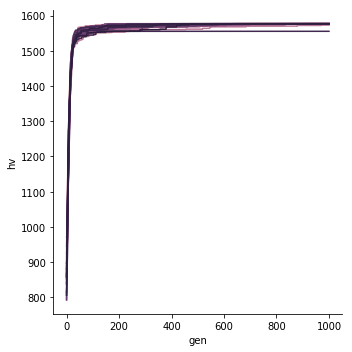

In [18]:
different_ids = len(pd.unique(hvs_df["run_id"]))
sns.relplot(x="gen", y="hv",
            data=hvs_df, hue="run_id",
            legend=False, kind="line", palette=sns.cubehelix_palette(different_ids));

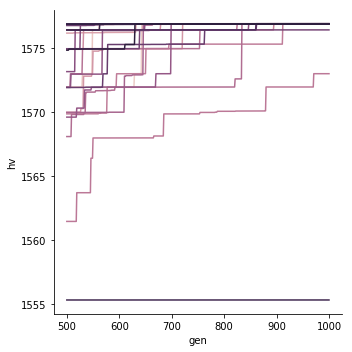

In [19]:
different_ids = len(pd.unique(hvs_df["run_id"]))
sns.relplot(x="gen", y="hv",
            data=hvs_df[hvs_df["gen"] >= 500], hue="run_id",
            legend=False, kind="line", palette=sns.cubehelix_palette(different_ids));